In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function

import sys
import os

import pandas as pd
import numpy as np

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

In [9]:
import os
os.chdir('D:\P_WORKPLACE')
os.getcwd()

'D:\\P_WORKPLACE'

In [12]:
filename_ts = '.\series1.csv'
ts_df = pd.read_csv(filename_ts, index_col=0, parse_dates=[0])

n_sample = ts_df.shape[0]
print(n_sample)

120


In [11]:
print(ts_df.shape)
print(ts_df.head())

(120, 1)
              value
2006-06-01  0.21507
2006-07-01  1.14225
2006-08-01  0.08077
2006-09-01 -0.73952
2006-10-01  0.53552


In [13]:
# Create a training sample and testing sample before analyzing the series

n_train=int(0.95*n_sample)+1
n_forecast=n_sample-n_train
#ts_df
ts_train = ts_df.iloc[:n_train]['value']
ts_test = ts_df.iloc[n_train:]['value']
print(ts_train.shape)
print(ts_test.shape)
print("Training Series:", "\n", ts_train.tail(), "\n")
print("Testing Series:", "\n", ts_test.head())

(115,)
(5,)
Training Series: 
 2015-08-01    0.60371
2015-09-01   -1.27372
2015-10-01   -0.93284
2015-11-01    0.08552
2015-12-01    1.20534
Name: value, dtype: float64 

Testing Series: 
 2016-01-01    2.16411
2016-02-01    0.95226
2016-03-01    0.36485
2016-04-01   -2.26487
2016-05-01   -2.38168
Name: value, dtype: float64


In [14]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

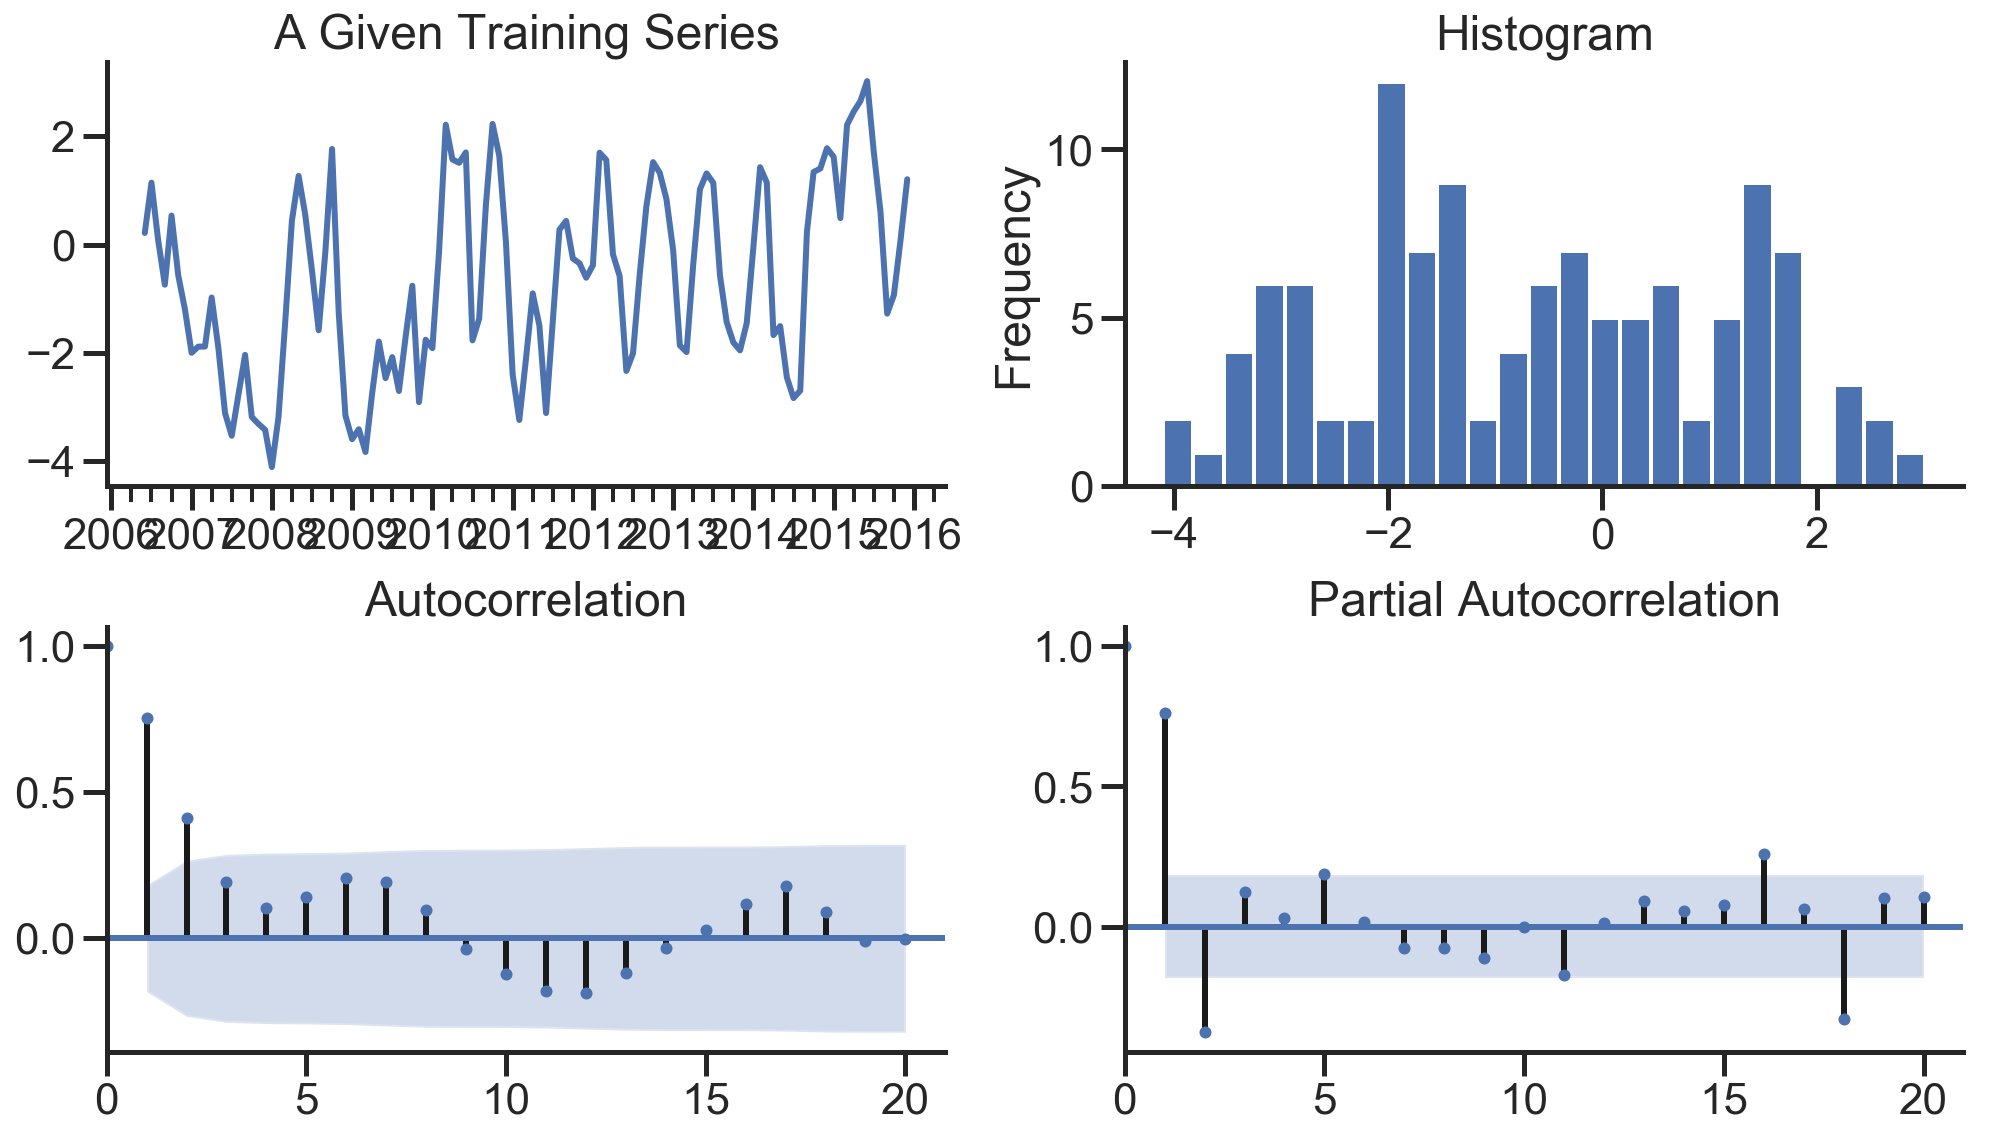

In [15]:
tsplot(ts_train, title='A Given Training Series', lags=20);

In [15]:
#Model Estimation

# Fit the model
arima200 = sm.tsa.SARIMAX(ts_train, order=(2,0,0))
model_results = arima200.fit()

In [8]:
import itertools

p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4

# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
    
    try:
        model = sm.tsa.SARIMAX(ts_train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihoo

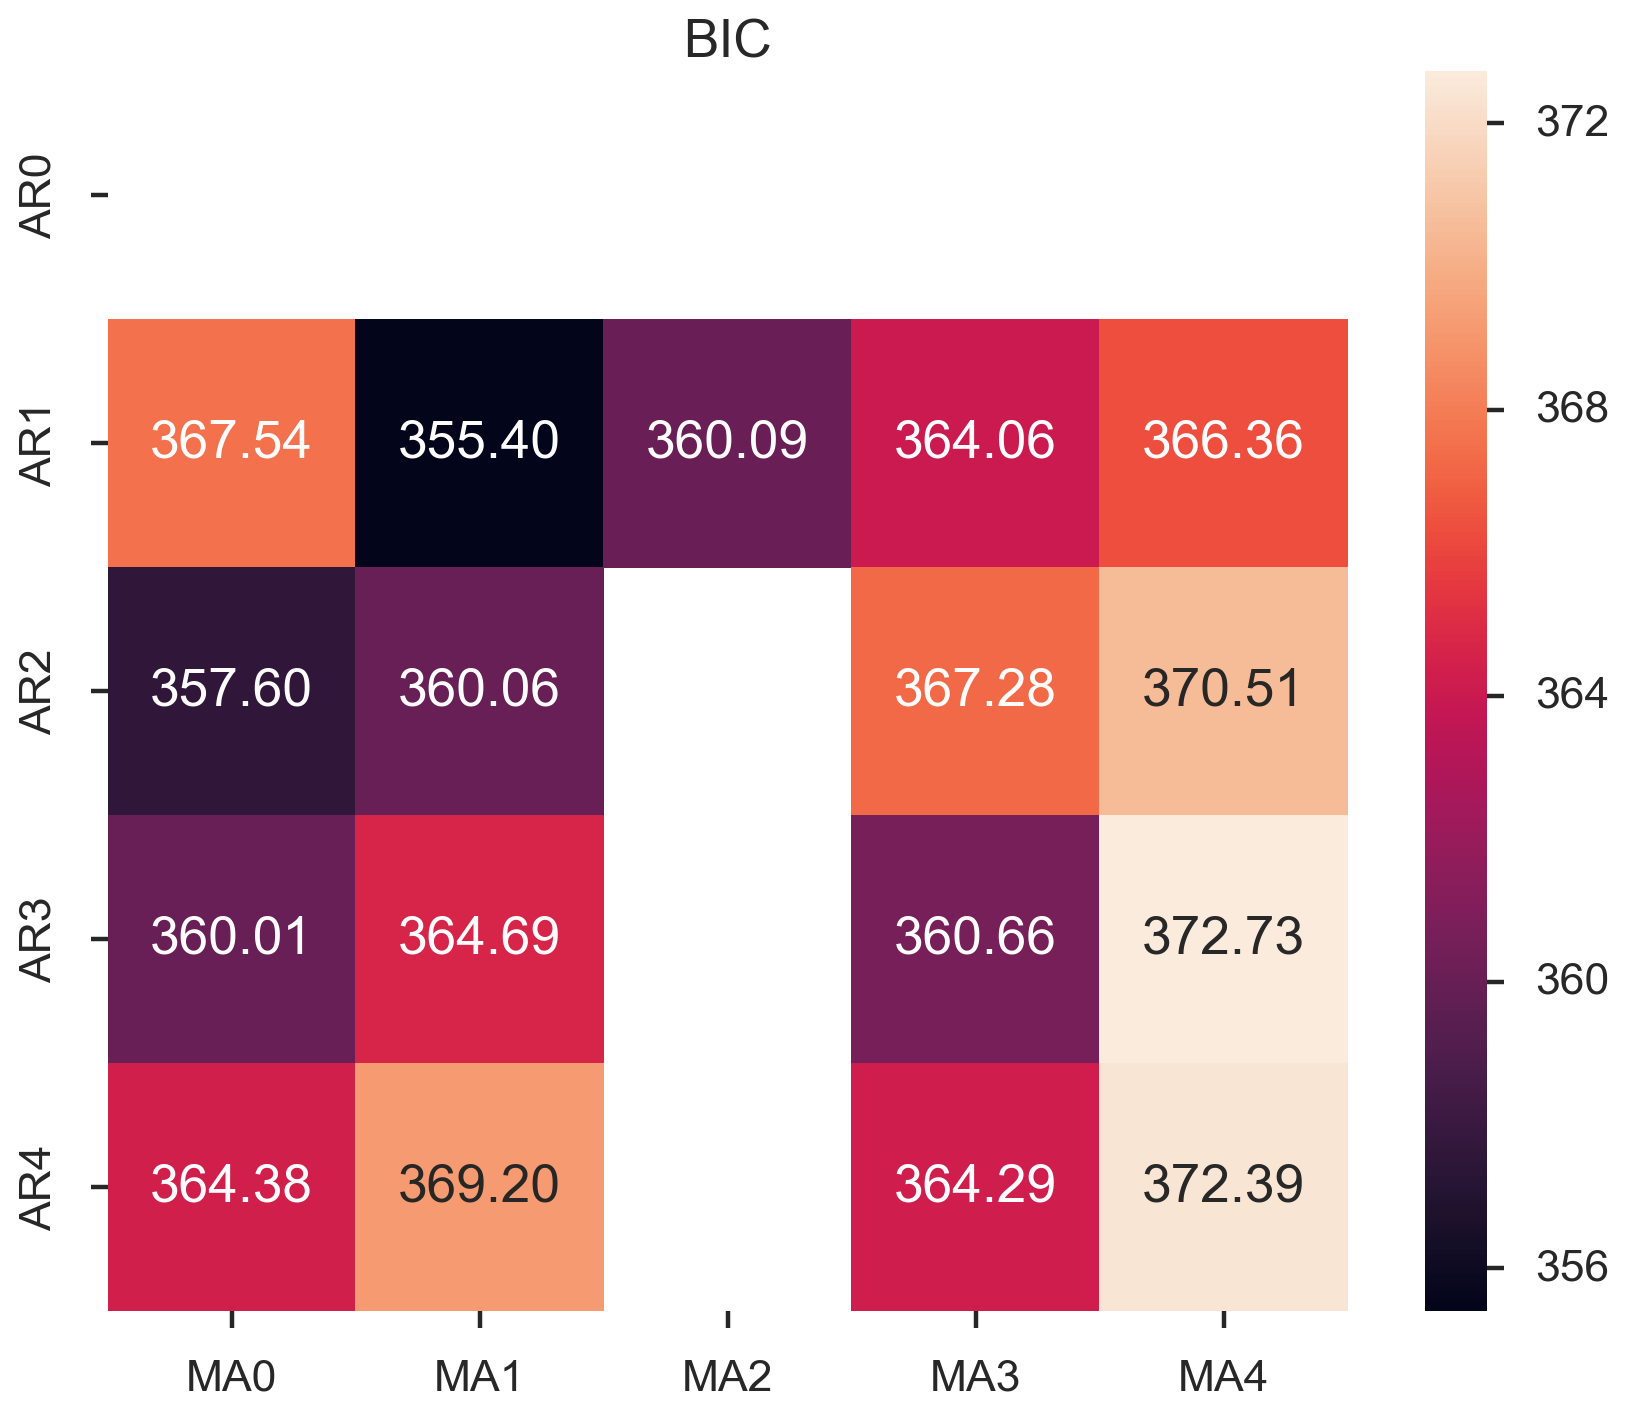

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('BIC');

In [10]:
# Alternative model selection method, limited to only searching AR and MA parameters

train_results = sm.tsa.arma_order_select_ic(ts_train, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC (4, 2)
BIC (1, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


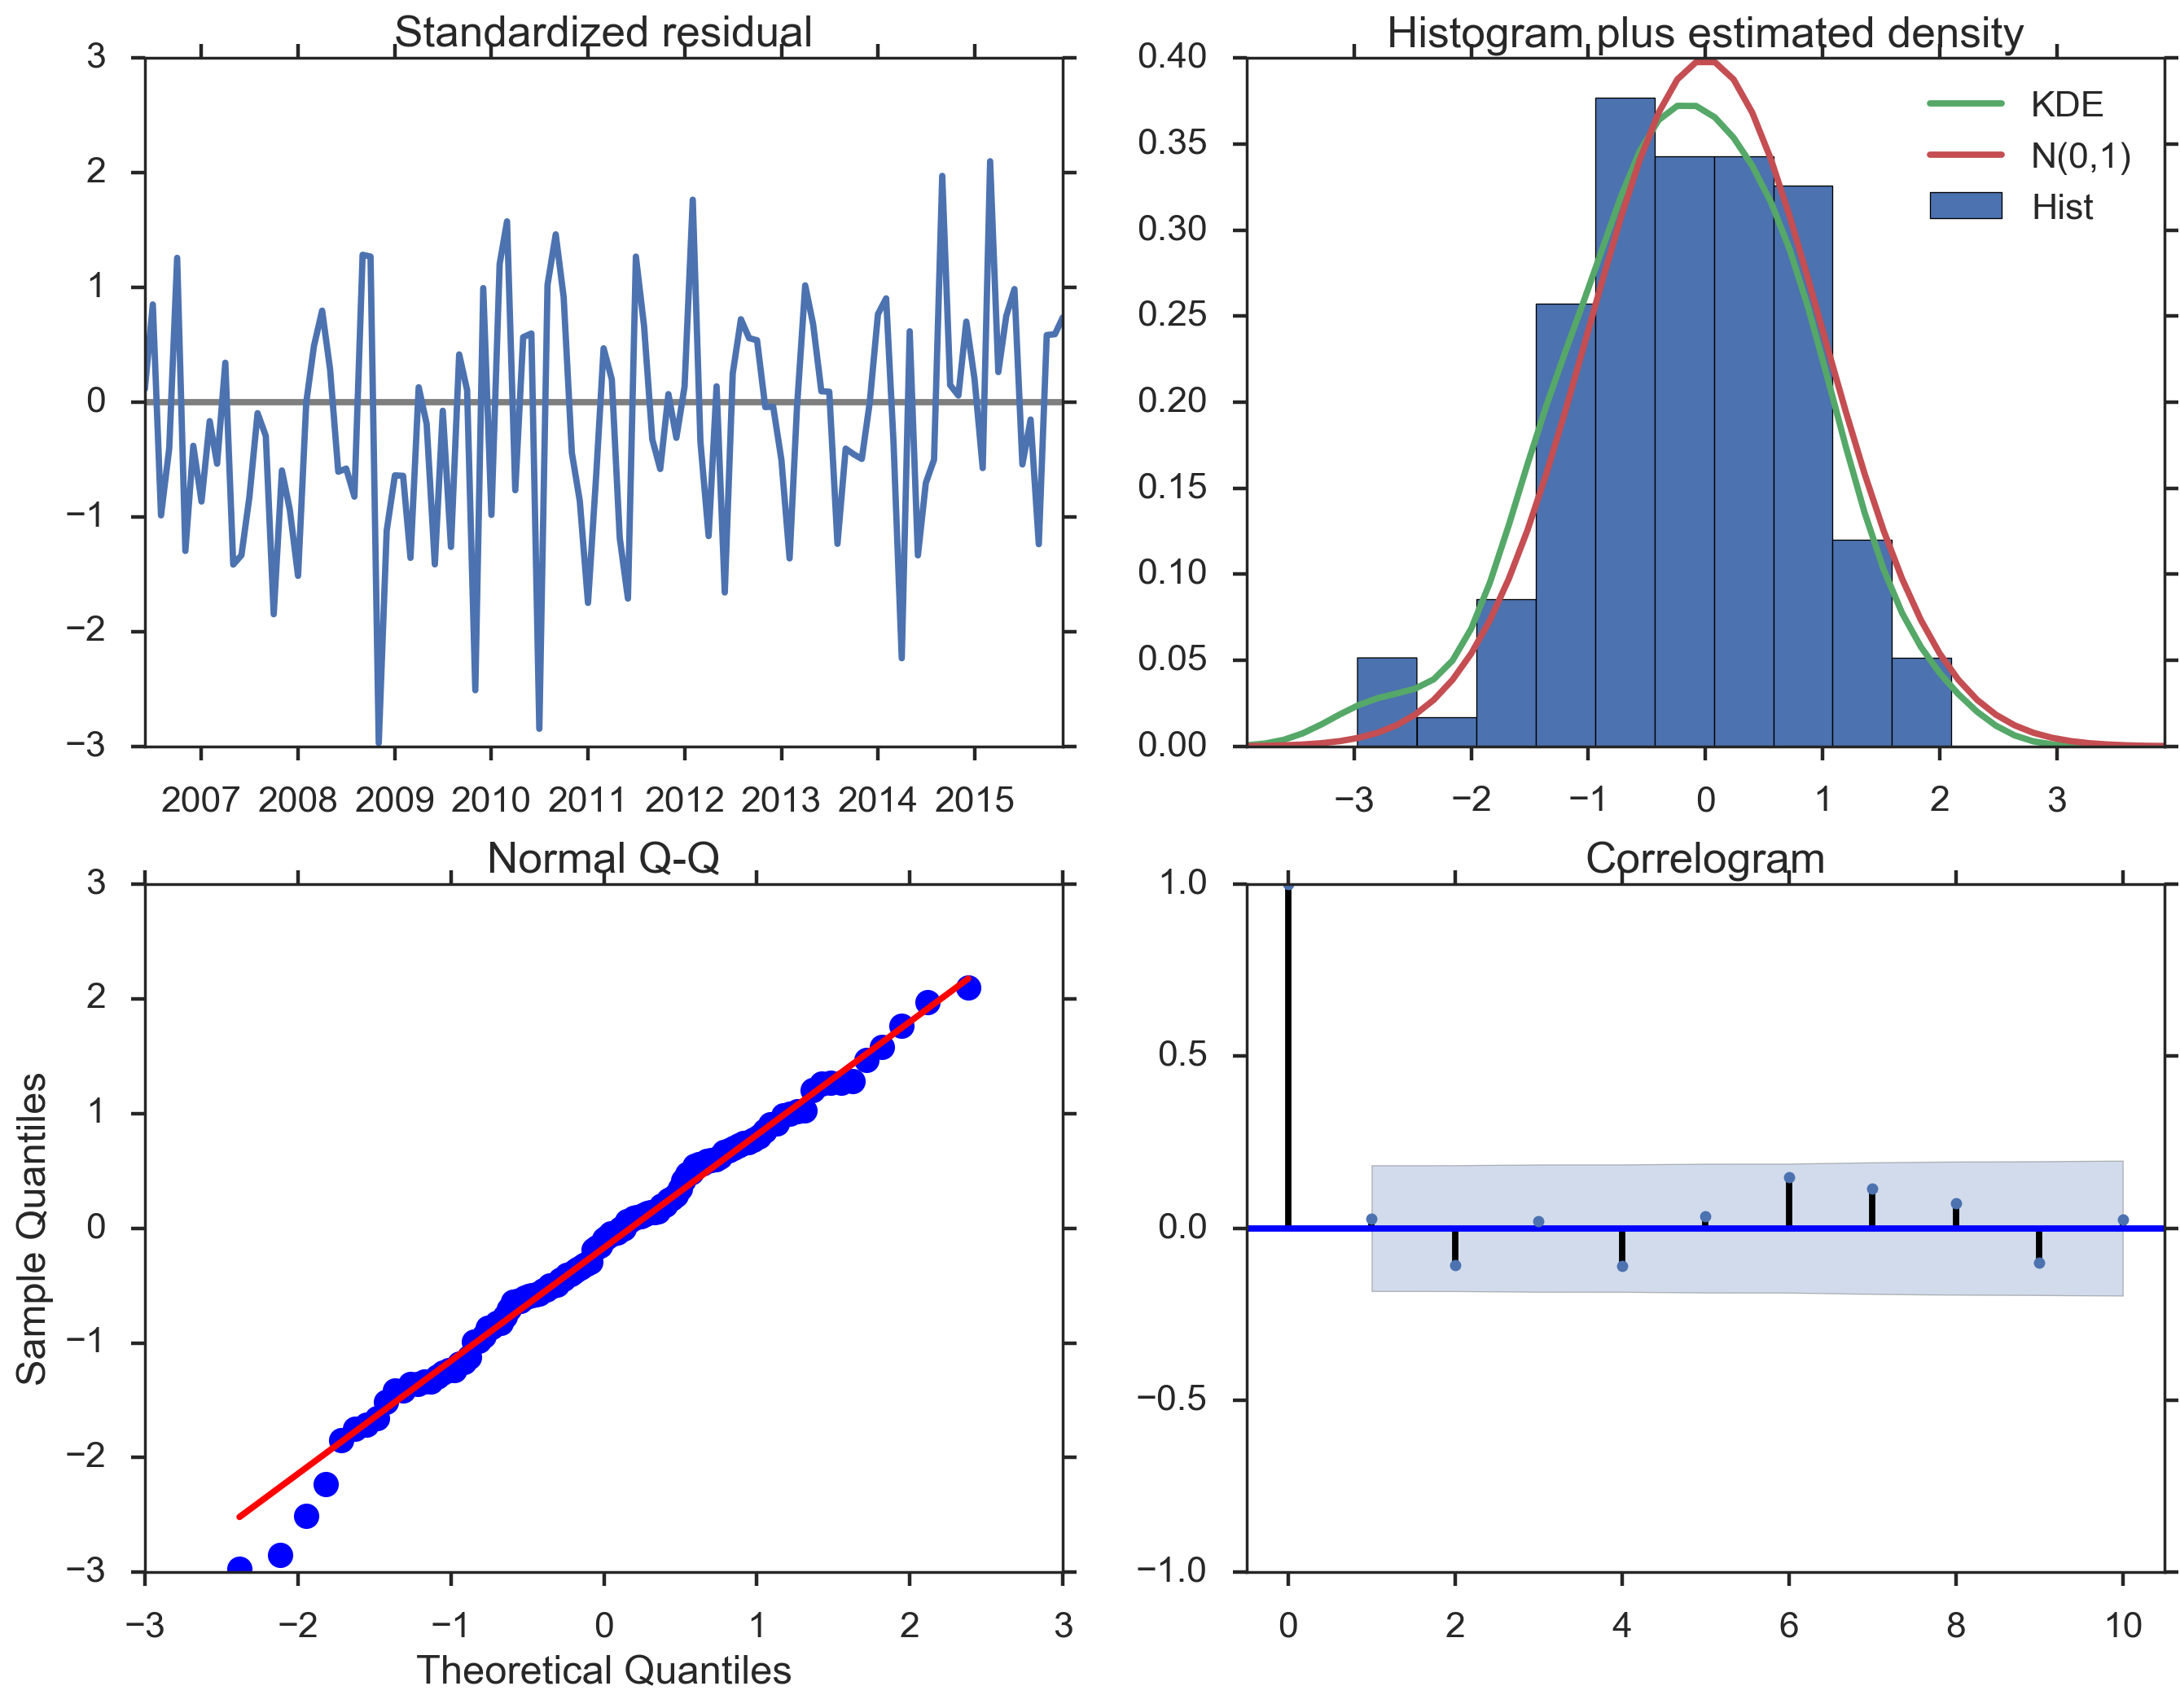

In [26]:
#残差分析 正态分布 QQ图线性
model_results.plot_diagnostics(figsize=(16, 12));